In [1]:
from pynq import Overlay, allocate
ol = Overlay("/home/xilinx/jupyter_notebooks/hakaton/accelerator_top.bit")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import time
from IPython.display import display
from PIL import Image
from pylab import *


In [3]:
dma0 = ol.axi_dma_0
dma1 = ol.axi_dma_1

In [4]:
IP_BASE_ADDRESS = ol.ip_dict['example_design_0']['phys_addr'] 
ADDRESS_RANGE = ol.ip_dict['example_design_0']['addr_range'] 

from pynq import MMIO
mmio = MMIO(IP_BASE_ADDRESS, ADDRESS_RANGE)

In [5]:
## mmio.write(4,12) # write 12 @ address offset 4

#check reset values are visible in memory-mapped registers
result1 = mmio.read(0) # read at offset 0
result2 = mmio.read(4) # read at offset 4
result3 = mmio.read(8) # ...
result4 = mmio.read(12)
print(result1)
print(result2)
print(result3)
print(result4)


1
1
0
0


In [6]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

#Load input image from located path and convert it to grayscale
def load_image(filepath):
    img = plt.imread(filepath)
    if (img.dtype == float) and (max(img.flatten())<=1):
        img = rgb2gray(img)
        img = np.clip(img, 0, 1) * 255
    else:
        img = rgb2gray(img)
        img = img.astype(np.uint8)
    return img

In [7]:
def sobel_matrix():
    sobel_h = np.array([[-1/8 , 0 , 1/8],[-1/4 , 0 , 1/4] ,[-1/8 , 0, 1/8]],dtype='float')
    sobel_v = np.array( [[-1/8 , -1/4 , -1/8],[0 , 0 , 0],[1/8 , 1/4 , 1/8]],dtype='float')
    return sobel_h,sobel_v

def process_image(img):
    img_in=img.astype(float)
    sobel_h,sobel_v = sobel_matrix()

    sobel_h_rez=ndimage.correlate(img_in,sobel_h,mode='reflect')
    sobel_v_rez=ndimage.correlate(img_in,sobel_v,mode='reflect')
    
    print(max(sobel_h_rez.flatten()))
    print(max(sobel_v_rez.flatten()))
    mag = np.sqrt(sobel_h_rez**2+sobel_v_rez**2)
    grad = np.arctan2(sobel_v_rez,sobel_h_rez)
    return mag,grad

In [8]:
def compare_img(img_sw,img_hw):

    img_diff=abs(img_hw-img_sw)
    max_error = max(abs(img_sw.flatten()-img_hw.flatten()))

    return img_diff,max_error

In [9]:
def padded_image(img):
    h,w=np.shape(img)
    padded_pic = np.zeros((h+2,w+2))

    ### padding the input picture with nearest rows and columns
    h_padded,w_padded=np.shape(padded_pic)
    ###original pic
    padded_pic[1:h_padded-1,1:w_padded-1]=img
    
    ###corners
    padded_pic[0][0]=img[0][0]
    padded_pic[0][w_padded-1]=img[0][w-1]
    padded_pic[h_padded-1][0]=img[h-1][0]
    padded_pic[h_padded-1][w_padded-1]=img[h-1][w-1]
    
    ###rows and columns
    padded_pic[0,1:w_padded-1]=img[0,:]
    padded_pic[h_padded-1,1:w_padded-1]=img[h-1]
    padded_pic[1:h_padded-1,0]=img[:,0]
    padded_pic[1:h_padded-1,w_padded-1]=img[:,w-1]
    
    return padded_pic
    


80.0
58.625


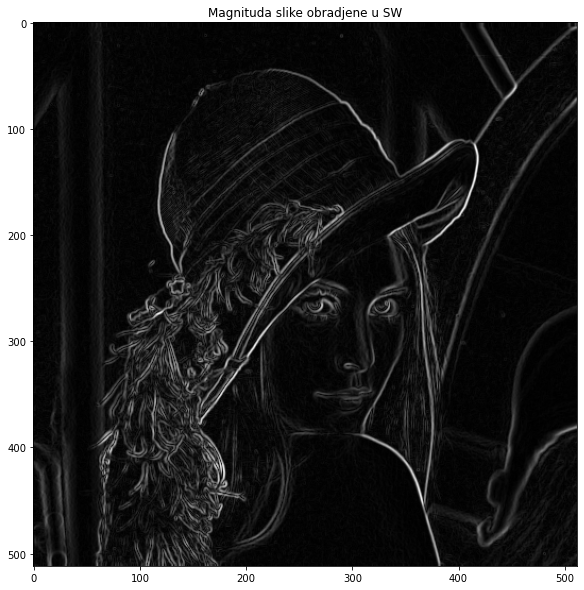

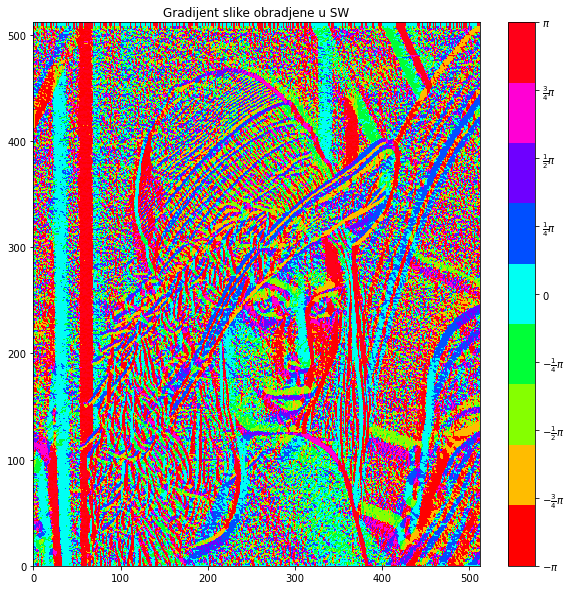

In [10]:
image = load_image('/home/xilinx/jupyter_notebooks/hakaton/lena_gray.gif')
image_mag_sw,image_grad_sw = process_image(image)
padded_img = padded_image(image)
plt.figure(figsize=(10,10))
plt.imshow(image_mag_sw,cmap='gray');
plt.title("Magnituda slike obradjene u SW");


plt.figure(figsize=(10,10))
cmap = plt.cm.get_cmap('hsv', 9)
plt.pcolormesh(np.flipud(image_grad_sw),cmap=cmap);

cbar = plt.colorbar();
ticks = np.linspace(-np.pi, np.pi, num=9);
cbar.set_ticks(ticks);
cbar.set_ticklabels([r"$-\pi$", r"$-\frac{3}{4}\pi$", r"$-\frac{1}{2}\pi$", r"$-\frac{1}{4}\pi$", r"$0$", r"$\frac{1}{4}\pi$", r"$\frac{1}{2}\pi$", r"$\frac{3}{4}\pi$", r"$\pi$"]);
plt.title("Gradijent slike obradjene u SW");


In [11]:
l,w = padded_img.shape
input_buffer   = allocate(shape=(l,w), dtype=np.uint8)
output_buffer1 = allocate(shape=(l,w), dtype=np.int8)
output_buffer2 = allocate(shape=(l,w), dtype=np.uint16)

In [12]:
input_buffer[:] = padded_img

In [13]:
t1 = time.perf_counter()

dma0.sendchannel.transfer(input_buffer)
dma0.recvchannel.transfer(output_buffer1)
dma1.recvchannel.transfer(output_buffer2)

dma0.sendchannel.wait()
dma0.recvchannel.wait()
dma1.recvchannel.wait()

t2 = time.perf_counter()

In [14]:

print("Time taken from starting DMA Tx to completing DMA Rx is "+str(t2-t1)+" seconds")

Time taken from starting DMA Tx to completing DMA Rx is 0.04340171100000134 seconds


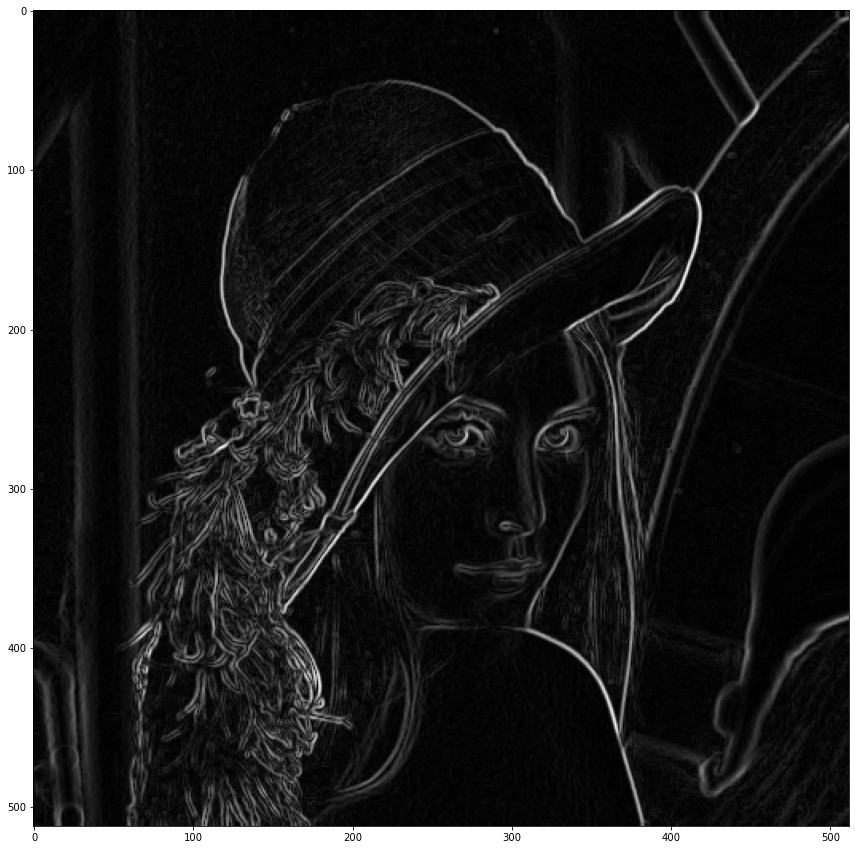

In [15]:
#image_mag = output_buffer1

image_mag = output_buffer2[2:,2:]
plt.figure(figsize=(15,15))
plt.imshow(image_mag,cmap='gray')


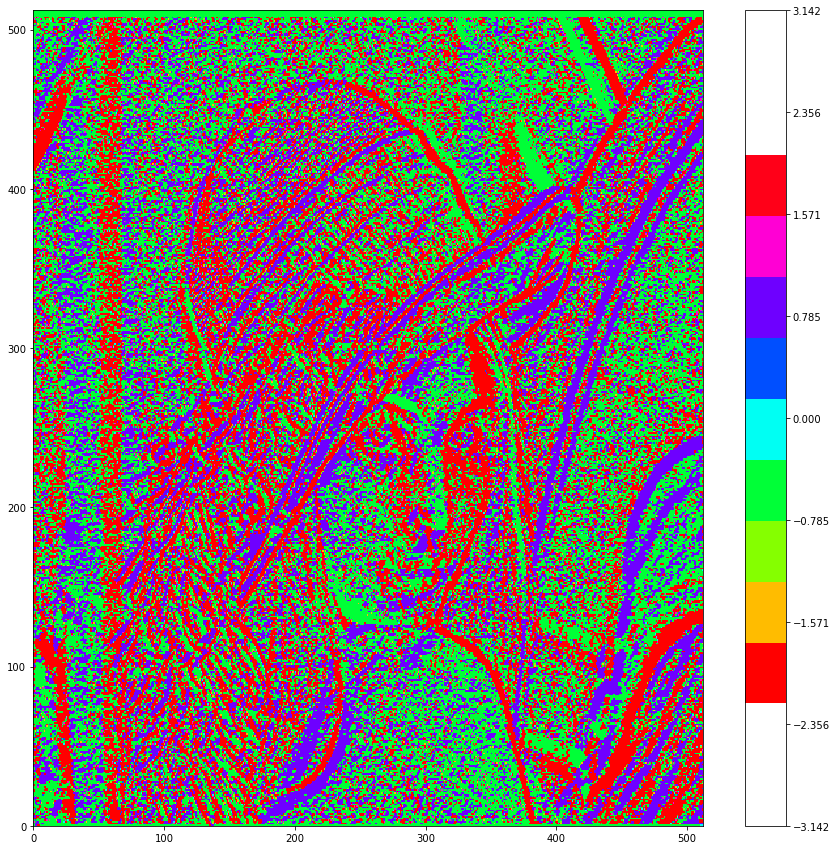

In [16]:
plt.figure(figsize=(15,15))
image_grad = output_buffer1[2:,2:] #zbog prosirivanja u slucaju drugacije implementacije moze se promeniti

image_grad = image_grad*0.0174532925# mnozenje kako bi se slika pretvorila u radijane
cmap = plt.cm.get_cmap('hsv', 9)
plt.pcolormesh(np.flipud(image_grad),cmap=cmap);

cbar = plt.colorbar();
ticks = np.linspace(-np.pi, np.pi, num=9);
cbar.set_ticks(ticks);

Maksimalna greska u izracunavanju magnitude gradijenta iznosi :  2.5
Maksimalna greska u izracunavanju ugla gradijenta iznosi :  5.340707508589793


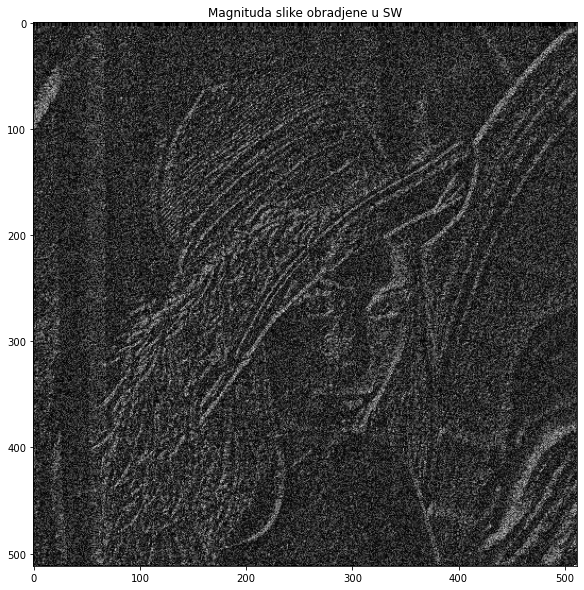

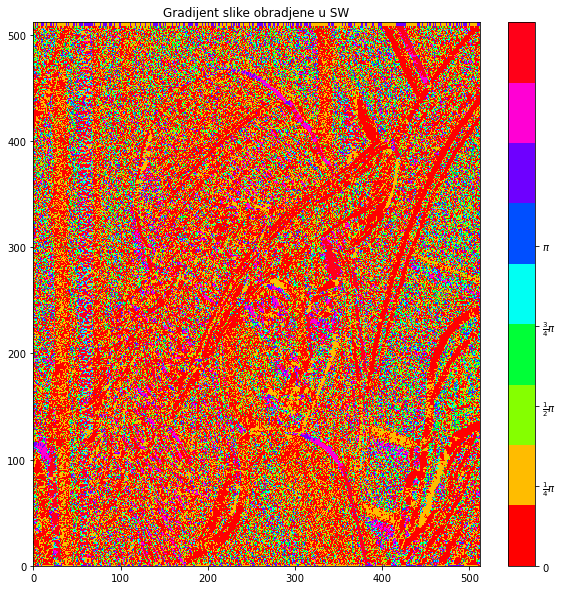

In [17]:
img_diff_mag,max_error_mag = compare_img(image_mag_sw,image_mag)
img_diff_grad,max_error_grad = compare_img(image_grad_sw,image_grad)
plt.figure(figsize=(10,10))
plt.imshow(img_diff_mag,cmap='gray');
plt.title("Magnituda slike obradjene u SW");


plt.figure(figsize=(10,10))
cmap = plt.cm.get_cmap('hsv', 9)
plt.pcolormesh(np.flipud(img_diff_grad),cmap=cmap);

cbar = plt.colorbar();
ticks = np.linspace(0, np.pi, num=5);
cbar.set_ticks(ticks);
cbar.set_ticklabels([r"$0$", r"$\frac{1}{4}\pi$", r"$\frac{1}{2}\pi$", r"$\frac{3}{4}\pi$", r"$\pi$"]);
plt.title("Gradijent slike obradjene u SW");

print("Maksimalna greska u izracunavanju magnitude gradijenta iznosi : " , max_error_mag)
print("Maksimalna greska u izracunavanju ugla gradijenta iznosi : " , max_error_grad)

In [ ]:
mmio.write(4,0) # example of writing into mm register that will cause example_design to not shift pixels on 8-bit stream